In [ ]:
# Connect Driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-federated


In [ ]:
!pip install tensorflow tensorflow-federated scikit-learn pandas matplotlib


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of Federated Averaging model: 0.8692


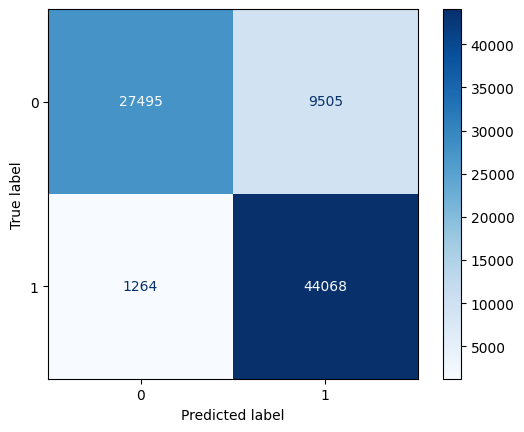

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CSV_HEADER: Danh sách các cột mà bạn muốn giữ lại
CSV_HEADER = [
    "dur", "proto", "service", "state", "spkts", "dpkts", "sbytes", "dbytes", "rate", "sttl", "dttl",
    "sload", "dload", "sloss", "dloss", "sinpkt", "dinpkt", "sjit", "djit", "swin", "stcpb", "dtcpb",
    "dwin", "tcprtt", "synack", "ackdat", "smean", "dmean", "trans_depth", "response_body_len",
    "ct_srv_src", "ct_state_ttl", "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm",
    "ct_dst_src_ltm", "is_ftp_login", "ct_ftp_cmd", "ct_flw_http_mthd", "ct_src_ltm",
    "ct_srv_dst", "is_sm_ips_ports", "label"
]

# Đọc dữ liệu từ các file CSV
train_data = pd.read_csv("/content/drive/MyDrive/lona/UNSW_NB15_training-set.csv", usecols=CSV_HEADER)
test_data = pd.read_csv("/content/drive/MyDrive/lona/UNSW_NB15_testing-set.csv", usecols=CSV_HEADER)

# Chuyển các cột dạng categorical thành one-hot encoding
categorical_columns = ['proto', 'service', 'state']  # Chỉ mã hóa các cột categorical (không bao gồm 'label')
for col in categorical_columns:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

# Sử dụng one-hot encoding cho các cột categorical
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Đảm bảo bộ dữ liệu kiểm tra có các cột giống như bộ dữ liệu huấn luyện
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

# Mã hóa nhãn thành số (Label Encoding) trước khi one-hot encoding
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])

# Tách các tính năng (features) và nhãn (labels)
X_train = train_data.drop(columns=['label'])  # Loại bỏ cột nhãn
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Tiền xử lý dữ liệu (Điền giá trị thiếu, chuẩn hóa, v.v...)
X_train = X_train.fillna(X_train.mean())  # Điền giá trị thiếu bằng giá trị trung bình
X_test = X_test.fillna(X_test.mean())

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Giả sử chia dữ liệu cho các client
num_clients = 3  # Giả sử có 3 client
X_train_split = np.array_split(X_train, num_clients)
y_train_split = np.array_split(y_train, num_clients)

# Huấn luyện mô hình cho mỗi client
client_models = []
for i in range(num_clients):
    model = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=50, random_state=42)
    model.fit(X_train_split[i], y_train_split[i])
    client_models.append(model)

# Thực hiện Federated Averaging
def federated_averaging(models):
    # Kiểm tra đồng nhất trọng số của các mô hình
    first_model = models[0]
    avg_weights = [np.copy(layer) for layer in first_model.coefs_]

    # Kiểm tra nếu các trọng số của các mô hình khác nhau có đồng nhất không
    for i, model in enumerate(models[1:], start=1):
        for layer_idx, (layer_weights, avg_weight) in enumerate(zip(model.coefs_, avg_weights)):
            if layer_weights.shape != avg_weight.shape:
                print(f"Layer {layer_idx} weights shape mismatch: client {i} model shape {layer_weights.shape}, first model shape {avg_weight.shape}")
                return None

    # Cộng trọng số của các client lại
    for model in models[1:]:
        for i in range(len(avg_weights)):
            avg_weights[i] += model.coefs_[i]

    # Trung bình trọng số
    avg_weights = [weights / len(models) for weights in avg_weights]

    return avg_weights

# Khởi tạo mô hình MLP
global_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42, early_stopping=True)

# Thực hiện Federated Averaging để tính trọng số trung bình
avg_weights = federated_averaging(client_models)

# Gán trọng số trung bình vào mô hình toàn cầu
global_model.coefs_ = avg_weights

# Huấn luyện mô hình toàn cầu với trọng số đã tính toán
# Lưu ý: MLPClassifier không cho phép gán trọng số trực tiếp, vậy nên bạn cần huấn luyện lại mô hình
global_model.fit(X_train, y_train)

# Đánh giá mô hình toàn cầu
y_pred_global = global_model.predict(X_test)
accuracy_global = accuracy_score(y_test, y_pred_global)
print(f"Accuracy of Federated Averaging model: {accuracy_global:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_global)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
